In [1]:
import findspark
findspark.init()
import pyspark # only run after findspark.init()

from pyspark.sql import SparkSession
from pyspark.context import SparkContext 
spark = SparkSession.builder.getOrCreate()#create spark session 
sc = spark.sparkContext#create sparkContext
from pyspark.sql.types import  (StructType, 
                                StructField, 
                                DateType, 
                                BooleanType,
                                DoubleType,
                                IntegerType,
                                StringType,
                                DecimalType,
                                LongType,
                                ArrayType,
                                TimestampType)

#Measurement Data File Format

#The header line of the measurement data files is as follows:
#id,timeAtServer,aircraft,latitude,longitude,baroAltitude,geoAltitude,numMeasurements,measurements

#1-id: a unique identifier for each received transponder signal. This identifier will be used to join the result file (output of your localization algorithm) with the measurement data.
#2-timeAtServer: a timestamp (double) in seconds indicating the time when the information was received by OpenSky's ingestion server.
#In each 1h data set, this timestamp starts with 0 and counts up to 3600 seconds. 
#This timestamp has roughly millisecond accuracy. 
#Note that this timestamp was determined after propagation delay, processing delay, and Internet delay.
#3-aircraft: an aircraft identifier which is unique for each aircraft within each data set. 
#This identifier allows grouping the measurements that belong to signals from the same transponder.
#Note that aircraft 123 in data set X is not the same transponder as aircraft 123 in data set Y. 
#This means that data sets cannot be combined.
#4-latitude/longitude/geoAltitude: the location that was reported by the transmitting aircraft. 
#As in the sensor meta data, latitude and longitude are provided in decimal degrees (WGS84), geoAltitude in meters. 
#The accuracy of these location information is generally unknown. 
#However, most aircraft should report their locations at a decent accuracy (10s of meters accuracy). 
#It is worth noting here that there are some aircraft sending location information derived from their intertial system rather that their GPS sensor.
#In this case, location information is subject to drifting and might be wrong by several hundred meters. 
#However, this case is rather rare but should nevertheless be considered when cleansing the data.
#5-baroAltitude: the barometric altitude reported by the aircraft in meters. 
#Note that the barometric altitude is weather dependent and might differ from the geometric altitude by several hundred meters.
#However, the difference might be learned from "known" aircraft and this information could then be used to estimate the geometric altitude or estimate bounds.
#6-numMeasurements: the number of measurements, i.e., the number of sensors which received this particular transponder signal.
#7-measurements: the measurement data for each receiver which received this particular transponder signal. 
#The measurement data is provided as a JSON array string containing triples.
#Each triple contains the serial number of the sensor which reported the measurement data, the timestamp for the time of arrival of the signal at the receiver (in nanoseconds), and the received signal strength indicator (RSSI).
#The exact definition of the RSSI depends on the type of receiver but is usually provided in dB. 
#The properties of the nanosecond timestamp also strongly depend of the type of receiver. 
#For dump1090 receivers, these timestamps are generally unsynchronized and typically have a 12MHz resolution. 
#Unsynchronized timestamp means in particular that these timestamps are subject to (sometimes heavy) drifting. 
#For Radarcape and GRX1090, these timestamps are usually GPS synchronized and have a resolution of about 40-60MHz. GPS synchronized means that they are constantly resynchronized to compensate for clock drift.
sample_schema = StructType([StructField("id",  IntegerType(), True),
                            StructField("timeAtServer", DoubleType(), True),
                            StructField("aircraft",  IntegerType(), True ),
                            StructField("latitude", DoubleType(), True),
                            StructField("longitude", DoubleType(), True  ),
                            StructField("baroAltitude", DoubleType(), True ),
                            StructField("geoAltitude", DoubleType(), True ),
                            StructField("numMeasurements",IntegerType(), True),
                            StructField("measurements", StringType(), True)           
                            ])
                               

sample_aircarft = spark.read.csv("C:/PFE/TEST/training_1_category_1.csv",
                       header = True, 
                        schema = sample_schema)


sample_aircarft.show(5)

sample_aircarft.printSchema()


+---+-------------------+--------+----------------+----------------+------------+-----------+---------------+--------------------+
| id|       timeAtServer|aircraft|        latitude|       longitude|baroAltitude|geoAltitude|numMeasurements|        measurements|
+---+-------------------+--------+----------------+----------------+------------+-----------+---------------+--------------------+
|  1|                0.0|    1787|49.5238952636719|7.80282271535773|      6400.8|    6537.96|              3|[[463,963309455,4...|
|  2|                0.0|    1605|50.4821311821372|7.35423320048564|     10363.2|   10500.36|              5|[[463,963756980,2...|
|  3|                0.0|    2022|45.9829505015228|8.61870574951172|     11277.6|   11445.24|              3|[[14,981538828,29...|
|  4|0.00100016593933105|    2359|47.8106379104873|9.30739182692308|     10820.4|   10965.18|              2|[[125,957894484,8...|
|  5|0.00100016593933105|    1283|49.8303533004502|5.40037412901183|      9753.6|  

In [2]:
sample_aircarft.select( 'aircraft','timeAtServer','latitude', 'longitude','geoAltitude').describe().show()

+-------+-----------------+------------------+------------------+-----------------+------------------+
|summary|         aircraft|      timeAtServer|          latitude|        longitude|       geoAltitude|
+-------+-----------------+------------------+------------------+-----------------+------------------+
|  count|          2074194|           2074194|           1974059|          1974059|           1974059|
|   mean|1405.320938639298|1818.6544352795643|49.105843928856316|7.545431754547419| 9300.356869760097|
| stddev|    809.000130626|1030.6661350541483|2.8839420829672093|4.493160773598425|3054.4550871929255|
|    min|                2|               0.0|  31.1536560058594|-10.6397214143173|            129.54|
|    max|             2769|   3599.9880001545|  61.6916307352357|  25.098620999244|          13921.74|
+-------+-----------------+------------------+------------------+-----------------+------------------+



In [3]:
#How many primary aircrafts are there?
# return distinct elements.
sample_aircarft.groupBy("aircraft").count().show()

+--------+-----+
|aircraft|count|
+--------+-----+
|     148| 6251|
|     463| 1933|
|    2142| 1821|
|    1088|  767|
|     496|  218|
|    2659|  664|
|    1645|   75|
|    1580|  514|
|    2580| 3281|
|    2387|   97|
|    2235| 1296|
|     540| 2536|
|     737|  326|
|    2563| 3131|
|     623| 3191|
|     243|    6|
|    1721| 3366|
|    1507| 2496|
|    1127|   63|
|    1896|   78|
+--------+-----+
only showing top 20 rows



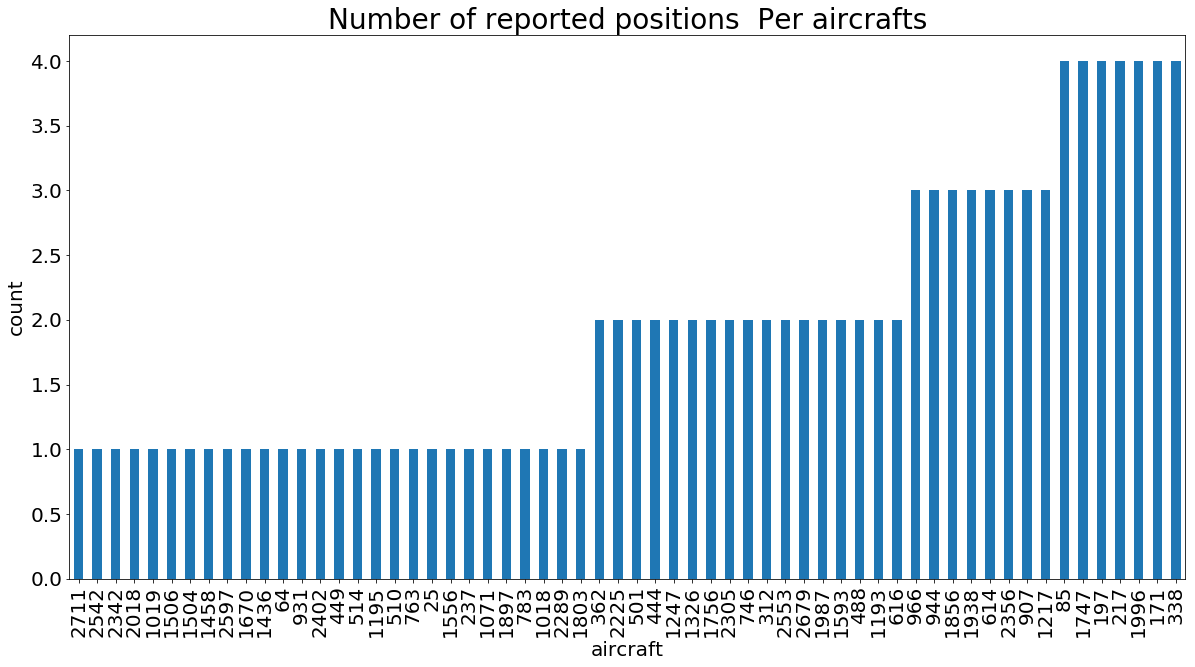

In [4]:
import plotly.graph_objs as go
import pandas as pd
import requests
import matplotlib.pyplot as plt
sample_aircarfs1=sample_aircarft.groupBy('aircraft').count()
sample_aircarfs1=sample_aircarfs1.orderBy('count')
#We can also use matplotlib and Pandas to visualize the total number of reported position for each aircraft   
import pandas as pd

%matplotlib inline
sample_aircarfs1 = pd.DataFrame.from_records(sample_aircarfs1.collect(), columns=sample_aircarfs1.columns)
#let's only show the 20 first aircrafts in the list.
sample_aircarfs1=sample_aircarfs1.iloc[:60,:]
sample_aircarfs1.plot(figsize = (20,10), kind = "bar",
                               x = "aircraft", y = "count", legend = False)

plt.xlabel("aircraft", fontsize = 20)
plt.ylabel("count", fontsize = 20)
plt.title("Number of reported positions  Per aircrafts", fontsize = 28)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.show()

In [8]:
#using Pandas power to analyse our filtred data
import pandas as pd
sample_aircarfts_DataFrame = pd.DataFrame.from_records(sample_aircarft.collect(), columns=sample_aircarft.columns)
#let's plot only  500 reported positions in our training data
sample_aircarfts_DataFrame=sample_aircarfts_DataFrame.iloc[:500,:]
sample_aircarfts_DataFrame.head(5)

,id,timeAtServer,aircraft,latitude,longitude,baroAltitude,geoAltitude,numMeasurements,measurements
0,1,0.000,1787,49.523895,7.802823,6400.8,6537.96,3,"[[463,963309455,4],[424,963315122,27],[412,963..."
1,2,0.000,1605,50.482131,7.354233,10363.2,10500.36,5,"[[463,963756980,25],[238,963870125,32],[115,96..."
2,3,0.000,2022,45.982951,8.618706,11277.6,11445.24,3,"[[14,981538828,29],[10,981594515,90],[477,9814..."
3,4,0.001,2359,47.810638,9.307392,10820.4,10965.18,2,"[[125,957894484,84],[123,957583812,94]]"
4,5,0.001,1283,49.830353,5.400374,9753.6,9906.00,5,"[[463,960120430,41],[424,960138097,44],[412,96..."


In [9]:
#using plotly 
import plotly.offline as py
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import json

sample_aircarfts_DataFrame['latitude'] = pd.to_numeric(sample_aircarfts_DataFrame['latitude'],errors='coerce')
sample_aircarfts_DataFrame['longitude'] = pd.to_numeric(sample_aircarfts_DataFrame['longitude'],errors='coerce')
sample_aircarfts_DataFrame['latitude'] = sample_aircarfts_DataFrame['latitude'].astype(float)
sample_aircarfts_DataFrame['longitude'] = sample_aircarfts_DataFrame['longitude'].astype(float)
sample_aircarfts_DataFrame=sample_aircarfts_DataFrame.dropna()
sample_aircarfts_DataFrame = [ dict(
        type = 'scattergeo',
        locationmode = 'ISO-3',
        lon = sample_aircarfts_DataFrame['longitude'],
        lat =sample_aircarfts_DataFrame['latitude'] ,
        hoverinfo = 'text',
        text = sample_aircarfts_DataFrame.aircraft,
        mode = 'markers',
        marker = dict(
            size=3,
            color='rgb(45, 100, 147)',
            line = dict(
                width=3,
                color='rgba(68, 68, 68, 0)'
            )
        ) ,
      name='sample_aircarfts')]




layout = dict(
        margin = dict( t = 0, l = 0, r = 0, b = 0 ),
        showlegend = False,         
        geo = dict(
            showland = True,
            showlakes = True,
            showcountries = True,
            showocean = True,
            countrywidth = 0.5,
            landcolor = 'rgb(230, 145, 56)',
            lakecolor = 'rgb(0, 255, 255)',
            oceancolor = 'rgb(0, 255, 255)',
            projection = dict( 
                type = 'orthographic',
                rotation = dict(lon = 0, lat = 0, roll = 0 )            
            ),
            lonaxis = dict( 
                showgrid = True,
                gridcolor = 'rgb(102, 102, 102)',
                gridwidth = 0.5
            ),
            lataxis = dict( 
                showgrid = True,
                gridcolor = 'rgb(102, 102, 102)',
                gridwidth = 0.5
            )
        )
    )

sliders = []

lon_range = np.arange(-180, 180, 10)
lat_range = np.arange(-90, 90, 10)

sliders.append( 
    dict(
        active = len(lon_range)/2,
        currentvalue = {"prefix": "Longitude: "},
        pad = {"t": 0},
        steps = [{
                'method':'relayout', 
                'label':str(i),
                'args':['geo.projection.rotation.lon', i]} for i in lon_range]
    )      
)

sliders.append( 
    dict(
        active = len(lat_range)/2,
        currentvalue = {"prefix": "Latitude: "},
        pad = {"t": 100},
        steps = [{
                'method':'relayout', 
                'label':str(i),
                'args':['geo.projection.rotation.lat', i]} for i in lat_range]
    )      
)

projections = [ "equirectangular", "mercator", "orthographic", "natural earth","kavrayskiy7", 
               "miller", "robinson", "eckert4", "azimuthal equal area","azimuthal equidistant", 
               "conic equal area", "conic conformal", "conic equidistant", "gnomonic", "stereographic", 
               "mollweide", "hammer", "transverse mercator", "albers usa", "winkel tripel" ]

buttons = [ dict( args=['geo.projection.type', p], label=p, method='relayout' ) for p in projections ]

annot = list([ dict( x=0.1, y=0.8, text='Projection', yanchor='bottom', 
                    xref='paper', xanchor='right', showarrow=False )])

# Update Layout Object

layout[ 'updatemenus' ] = list([ dict( x=0.1, y=0.8, buttons=buttons, yanchor='top' )])

layout[ 'annotations' ] = annot

layout[ 'sliders' ] = sliders
fig = dict( data=sample_aircarfts_DataFrame , layout=layout )
py.iplot( fig)
